In [2]:
from selenium import webdriver as wd
import urllib

In [3]:
target_url = 'http://www.opinet.co.kr/searRgSelect.do'

In [4]:
driver = wd.Chrome('../tool/chromedriver.exe')

In [5]:
# 해당 사이트가 중간 페이지를 직접 접속하는 것을 거부하기 때문에
import time
for n in range(2) :
    driver.get(target_url)
    time.sleep(5)

In [7]:
# 시도 리스트 획득
sido = driver.find_element_by_id('SIDO_NM0')
sidos = [ option.get_attribute('value')
         for option in driver.find_elements_by_css_selector('#SIDO_NM0 > option')
         if option.get_attribute('value')]
# 데이터의 상위값, 하위값 조사를 통해 샘플링으로 확인
sidos[:2], sidos[-2:]

(['서울특별시', '부산광역시'], ['경상남도', '제주특별자치도'])

In [ ]:
# 2. 시도 리스트를 반복하면서 해당 시도 밑에 시군구 리스트화
# sidos 중에 '부산광역시' 대상으로 수집
for sido_name in sidos[1:2] :
    # 2-1. sido 대상 찾아서
    sido = driver.find_element_by_id('SIDO_NM0')
    # 2-2. sido 값을 설정
    sido.send_keys(sido_name)
    # 2-2-2. 잠시대기(ajax 통신 후 화면이 재구성될 때까지)
    time.sleep(5)
    # 2-3. 시군구 리스트 획득
    sigungus = [option.get_attribute('value')
               for option in driver.find_elements_by_css_selector('#SIGUNGU_NM0 > option')
               if option.get_attribute('value')]
   
    # 3. 시군구 리스트를 반복하면서 -> 잠시대기(5초 대기) -> 엑셀 저장
    for sigungu_name in sigungus :
        # 3-1. 시군구 태그를 찾아서
        sigungu = driver.find_element_by_id('SIGUNGU_NM0')
        # 3-2. 시군구값 설정
        sigungu.send_keys(sigungu_name)
        # 3-3. 잠시 대기
        time.sleep(5)
        # 3-4. 조회
        driver.find_element_by_id('searRgSelect').click()
        # 3-5. 엑셀 저장
        driver.find_element_by_id('glopopd_excel').click()

### 데이터 수집 완료
- 수십 개의 엑셀 파일을 반복적으로 읽어서 DataFrame으로 구성하기

In [4]:
# glob : 특정 위치상에 존재하는 파일들을 패턴을 지정하여 목록을 구할 수 있다
from glob import glob
import pandas as pd

In [5]:
# 부산 관할 시군구에 조회된 엑셀 자료들을 읽을 수 있게 파일 경로를 리스트화
down_files = glob('C:/study/git/py_projects/analysis/crawling/data/지역*.xls')
down_files

['C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (1).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (10).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (11).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (12).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (13).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (14).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (15).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (2).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (3).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (4).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (5).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (6).xls',
 'C:/study/git/py_projects/analysis/crawling/data\\지역_위치별(주유소) (7).xls',
 'C:/study/git/py_projects/analysis/crawling/

In [6]:
# conda install xlrd

In [7]:
tmp_raws = []
for file in down_files :
    tmp = pd.read_excel(file, header=2)
    tmp_raws.append(tmp)

In [8]:
type(tmp_raws)

list

In [9]:
# 데이터 확인
st_raw = pd.concat(tmp_raws)
type(st_raw)

pandas.core.frame.DataFrame

In [10]:
st_raw.head(3)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,부산광역시,청룡명품주유소,부산 금정구 중앙대로2130,현대오일뱅크,051-508-5150,N,-,1442,1292,-
1,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1443,1293,-
2,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1443,1293,-


In [11]:
st_raw.shape

(422, 10)

In [12]:
st_raw.columns

Index(['지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유', '실내등유'], dtype='object')

In [13]:
# 주소에서 자치구만 추출해 '자치구' 컬럼 만들기
gus = st_raw['주소'].apply(lambda x : x.split()[1])
gus

0     금정구
1     금정구
2     금정구
3     금정구
4     금정구
5     금정구
6     금정구
7     금정구
8     금정구
9     금정구
10    금정구
11    금정구
12    금정구
13    금정구
14    금정구
15    금정구
16    금정구
17    금정구
18    금정구
19    금정구
20    금정구
21    금정구
22    금정구
23    금정구
0      서구
1      서구
2      서구
3      서구
4      서구
5      서구
     ... 
19    강서구
20    강서구
21    강서구
22    강서구
23    강서구
24    강서구
25    강서구
26    강서구
27    강서구
28    강서구
29    강서구
30    강서구
31    강서구
32    강서구
33    강서구
34    강서구
35    강서구
36    강서구
37    강서구
38    강서구
39    강서구
40    강서구
41    강서구
42    강서구
43    강서구
44    강서구
45    강서구
46    강서구
47    강서구
48    강서구
Name: 주소, Length: 422, dtype: object

In [14]:
data = st_raw
data['자치구'] = gus

In [15]:
data.head()

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
0,부산광역시,청룡명품주유소,부산 금정구 중앙대로2130,현대오일뱅크,051-508-5150,N,-,1442,1292,-,금정구
1,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1443,1293,-,금정구
2,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1443,1293,-,금정구
3,부산광역시,은마석유 노포주유소,부산 금정구 중앙대로 2191 (노포동),GS칼텍스,051-508-1645,Y,-,1443,1293,1050,금정구
4,부산광역시,광신석유(주)직영경부고속주유소,부산 금정구 중앙대로1720번길 7 (부곡동),SK에너지,051-517-6011,Y,-,1455,1315,1010,금정구


## 응용
- 부산시 행정구역별 주유소 정보 데이터
- 자치구별 가장 저렴한 주유소 마킹
- 행정구역별 주유가격 평균을 통해서 칼라맵으로 표시 (휘발유 기준, 가격없는 주유소 배제)
- 브랜드별(6개) 알뜰주유소 vs 브랜드 대비 진짜 싼 지 체크

## 부산시 행정구역별 주유소 정보 데이터

In [16]:
data.dtypes

지역       object
상호       object
주소       object
상표       object
전화번호     object
셀프여부     object
고급휘발유    object
휘발유      object
경유       object
실내등유     object
자치구      object
dtype: object

In [17]:
# '휘발유' 데이터에 '-'가 존재
data['휘발유'].unique()

array([1442, 1443, 1455, 1458, 1463, 1465, 1468, 1469, 1483, 1488, 1497,
       1498, 1519, 1535, 1539, 1577, 1665, 1438, 1440, 1448, 1478, 1548,
       1437, 1477, 1485, 1495, 1547, 1620, 1638, 1648, 1453, 1479, 1482,
       1518, 1598, 1628, 1644, 1398, 1565, 1427, 1434, 1435, 1445, 1475,
       1505, 1523, 1553, 1563, 1613, 1459, 1487, 1490, 1494, 1545, 1649,
       1419, 1420, 1424, 1447, 1457, 1467, 1489, 1508, 1538, 1569, 1585,
       1446, 1845, 1499, 1699, 1425, 1428, 1429, 1471, 1528, 1575, 1433,
       1509, 1544, 1414, 1415, 1418, 1464, 1579, 1597, 1599, 1729, '1430',
       '1447', '1448', '1452', '1458', '1468', '1478', '1487', '1488',
       '1489', '1495', '1497', '1498', '1508', '1518', '1563', '-', 1529],
      dtype=object)

In [18]:
# '-' 제외
data = data[data['휘발유']!='-']

In [19]:
data.shape

(419, 11)

In [20]:
data['휘발유'].dtype

dtype('O')

In [21]:
# '휘발유' 데이터 정수형으로 변환
data['휘발유'] = data['휘발유'].astype(int)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
data.head(2)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
0,부산광역시,청룡명품주유소,부산 금정구 중앙대로2130,현대오일뱅크,051-508-5150,N,-,1442,1292,-,금정구
1,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1443,1293,-,금정구


In [23]:
data = data.iloc[:, [1, 2, 3, 5, 7, -1]]

In [24]:
data.head()

,상호,주소,상표,셀프여부,휘발유,자치구
0,청룡명품주유소,부산 금정구 중앙대로2130,현대오일뱅크,N,1442,금정구
1,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,N,1443,금정구
2,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,N,1443,금정구
3,은마석유 노포주유소,부산 금정구 중앙대로 2191 (노포동),GS칼텍스,Y,1443,금정구
4,광신석유(주)직영경부고속주유소,부산 금정구 중앙대로1720번길 7 (부곡동),SK에너지,Y,1455,금정구


In [25]:
data.dtypes

상호      object
주소      object
상표      object
셀프여부    object
휘발유      int32
자치구     object
dtype: object

In [26]:
data['자치구'].unique()

array(['금정구', '서구', '수영구', '연제구', '영도구', '중구', '해운대구', '기장군', '남구', '동구',
       '동래구', '부산진구', '북구', '사상구', '사하구', '강서구'], dtype=object)

In [27]:
avg_price = pd.pivot_table(data,
              index = ['자치구'])
avg_price

,휘발유
자치구,
강서구,1476.612245
금정구,1485.708333
기장군,1461.217391
남구,1483.800000
동구,1497.100000
동래구,1472.250000
부산진구,1476.166667
북구,1464.842105
사상구,1470.696429


In [28]:
# min, max scaler를 이용한 정규화를 통해서 가격비율 컬럼을 생성
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [29]:
avg_price.values

array([[1476.6122449 ],
       [1485.70833333],
       [1461.2173913 ],
       [1483.8       ],
       [1497.1       ],
       [1472.25      ],
       [1476.16666667],
       [1464.84210526],
       [1470.69642857],
       [1473.        ],
       [1468.16666667],
       [1498.41176471],
       [1464.88235294],
       [1532.58333333],
       [1481.5       ],
       [1479.30769231]])

In [30]:
x = avg_price.values
x_scaled = min_max_scaler.fit_transform(x.astype(float))
x_scaled

array([[0.21571709],
       [0.34317409],
       [0.        ],
       [0.31643397],
       [0.50279738],
       [0.15459207],
       [0.20947352],
       [0.05079053],
       [0.13282298],
       [0.16510128],
       [0.09737523],
       [0.5211782 ],
       [0.05135449],
       [1.        ],
       [0.28420572],
       [0.25348647]])

In [31]:
tmp = pd.DataFrame(x_scaled,
                  columns = ['휘발유정규화'],
                  index = avg_price.index)

In [33]:
tmp.head()

,휘발유정규화
자치구,
강서구,0.215717
금정구,0.343174
기장군,0.000000
남구,0.316434
동구,0.502797


## 행정구역별 주유가격 평균을 통해서 칼라맵으로 표시

In [34]:
import folium

In [35]:
gps = [ 35.1564294,129.0603389 ]

In [37]:
import json
geo_str = json.load( open('../pandas/data/busan.json', encoding='utf-8') )

In [76]:
map_busan = folium.Map(location = gps, zoom_start = 10)
folium.Choropleth(geo_data = geo_str,
                 name = 'busan',
                 data = tmp,
                 columns = [tmp.index, '휘발유정규화'],
                 key_on = 'feature.id',
                 fill_color = 'PuRd',
                 legend_name = '부산시 자치구별 휘발유가격 비율').add_to(map_busan)
map_busan

## 알뜰주유소 vs 브랜드 가격 비교

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [67]:
from korea_font import initKoreaFontLoad
initKoreaFontLoad()

Malgun Gothic


###### .boxplot()

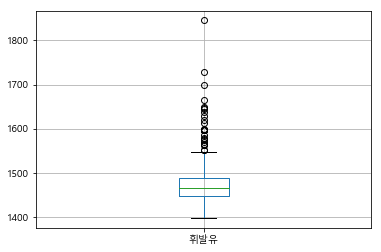

In [68]:
data.boxplot(column='휘발유')

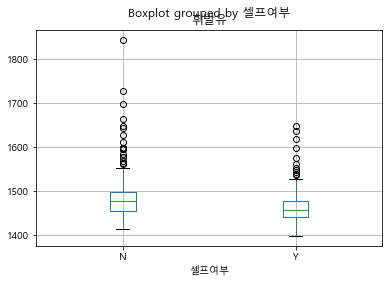

In [71]:
data.boxplot(column='휘발유', by = '셀프여부')

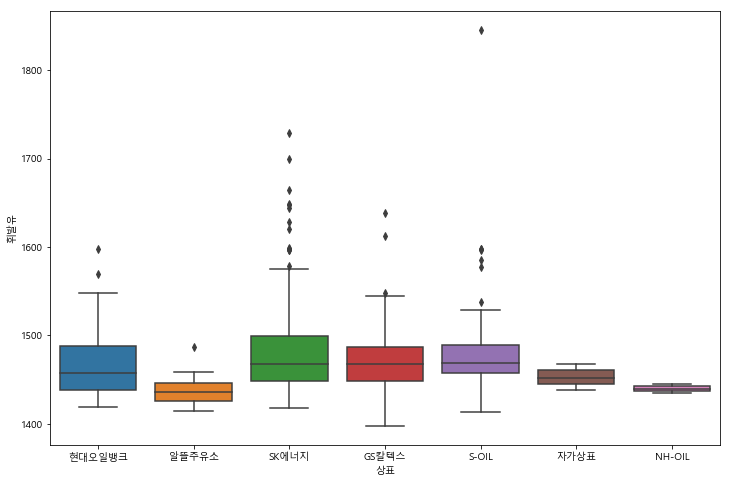

In [74]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='상표', y = '휘발유', data=data)
plt.show()

###### .swarmplot()

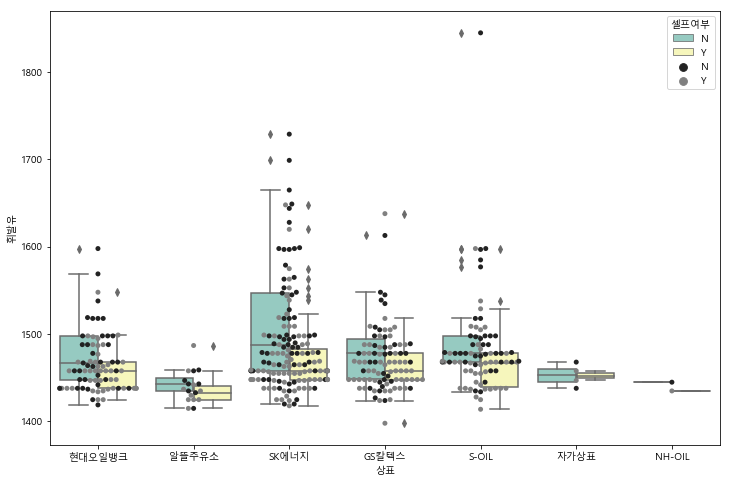

In [75]:
plt.figure(figsize=(12, 8))
# hue 속성
sns.boxplot(x='상표', y = '휘발유', hue='셀프여부', data=data, palette='Set3')
sns.swarmplot(x='상표', y = '휘발유', hue='셀프여부', data=data, color = '.5')
plt.show()

In [77]:
# 알뜰주유소는 부산 전역 모든 주유소 대비 4.3%
len(data[data['상표']=='알뜰주유소']) / len(data) * 100

4.295942720763723

## 자치구별 가장 저렴한/비싼 주유소 마킹

In [45]:
data.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
           dtype='int64', length=419)

###### 재인덱스 : (데이터).reset_index(inplace = True/False)

In [46]:
# 인덱스 중복
# -> 재인덱스 작업 필요
data.reset_index(inplace=True)

In [49]:
data.tail()

,index,상호,주소,상표,셀프여부,휘발유,자치구
414,44,광신석유(주)직영부산신항주유소,부산 강서구 르노삼성대로 372 (명지동),SK에너지,Y,1509,강서구
415,45,명지주유소,부산 강서구 낙동남로 1042,SK에너지,N,1518,강서구
416,46,만선주유소,부산 강서구 가락대로210번길 102,현대오일뱅크,N,1518,강서구
417,47,동성셀프주유소,부산광역시 강서구 명지국제8로 272 (명지동),S-OIL,Y,1529,강서구
418,48,SK에너지(주)새부산주유소,부산 강서구 낙동북로 42 (강동동),SK에너지,N,1545,강서구


In [50]:
# 불필요한 index 컬럼이 생성 -> 제거
del data['index']

In [52]:
data.tail()

,상호,주소,상표,셀프여부,휘발유,자치구
414,광신석유(주)직영부산신항주유소,부산 강서구 르노삼성대로 372 (명지동),SK에너지,Y,1509,강서구
415,명지주유소,부산 강서구 낙동남로 1042,SK에너지,N,1518,강서구
416,만선주유소,부산 강서구 가락대로210번길 102,현대오일뱅크,N,1518,강서구
417,동성셀프주유소,부산광역시 강서구 명지국제8로 272 (명지동),S-OIL,Y,1529,강서구
418,SK에너지(주)새부산주유소,부산 강서구 낙동북로 42 (강동동),SK에너지,N,1545,강서구


In [58]:
import numpy as np
# 데이터를 자치구별로 통합 -> 피벗테이블 -> 휘발유가격의 최소, 최대 포함
# aggfunc=[np.min, np.max]
min_max_df = pd.pivot_table(data,
                           index = '자치구',
                           aggfunc = [np.min, np.max])
min_max_df.head(2)

amin                                                         amax  \
        상표                상호 셀프여부                      주소   휘발유      상표   
자치구                                                                       
강서구  GS칼텍스  (주)DJS신항만물류단지주유소    N  부산 강서구 가락대로 1361 (봉림동)  1437  현대오일뱅크   
금정구  GS칼텍스            A1 주유소    N    부산 금정구  반송로 391 (서동)  1442  현대오일뱅크   

                                                    
           상호 셀프여부                        주소   휘발유  
자치구                                                 
강서구     현대주유소    Y    부산광역시 강서구 호계로 200(죽동동)  1545  
금정구  훼미리알뜰주유소    Y  부산광역시 금정구 중앙대로 2044(남산동)  1665

In [63]:
# 강서구로 확인
data[data['자치구'] == '강서구'].sort_values(by='휘발유', ascending = True).head(2)
# 피벗의 결과 휘발유는 정확하나 그 외 정보가 부정확하다 (모든 컬럼에 min, max가 적용된 듯)

,상호,주소,상표,셀프여부,휘발유,자치구
370,공항대로주유소,부산 강서구 공항로 1217 (대저1동),S-OIL,Y,1437,강서구
371,(주)우양네트웍스 송산주유소,부산광역시 강서구 호계로 200(죽동동),S-OIL,Y,1437,강서구


In [ ]:
# 피벗으로 휘발유가격 최소/최대만 남겨서 df를 뽑으면
# 그 가격에 일치하는 나머지 데이터를 뽑아서 최종 최소/최대 주유소 정보를 추출

In [79]:
min_max_df = pd.pivot_table(data,
                           index = '자치구',
                            values = '휘발유',
                           aggfunc = [np.min, np.max])
min_max_df

,amin,amax
,휘발유,휘발유
자치구,,
강서구,1437,1545
금정구,1442,1665
기장군,1435,1649
남구,1419,1598
동구,1446,1845
동래구,1437,1699
부산진구,1425,1598
북구,1425,1553


In [93]:
min_max_df.columns
# 컬럼의 depth가 1 이상

MultiIndex(levels=[['amin', 'amax'], ['휘발유']],
           labels=[[0, 1], [0, 0]])

In [86]:
# 최솟값만 추출
min_max_df['amin']

,휘발유
자치구,
강서구,1437
금정구,1442
기장군,1435
남구,1419
동구,1446
동래구,1437
부산진구,1425
북구,1425
사상구,1414


In [84]:
# 숫자만 나오도록
min_max_df['amin']['휘발유']

자치구
강서구     1437
금정구     1442
기장군     1435
남구      1419
동구      1446
동래구     1437
부산진구    1425
북구      1425
사상구     1414
사하구     1430
서구      1438
수영구     1437
연제구     1437
영도구     1497
중구      1398
해운대구    1427
Name: 휘발유, dtype: int32

In [89]:
for idx, oil_price in enumerate(min_max_df['amin']['휘발유']) :
    # 출력 형태 : 자치구, 가격
    print(min_max_df.index[idx], oil_price)

강서구 1437
금정구 1442
기장군 1435
남구 1419
동구 1446
동래구 1437
부산진구 1425
북구 1425
사상구 1414
사하구 1430
서구 1438
수영구 1437
연제구 1437
영도구 1497
중구 1398
해운대구 1427


In [94]:
min_max_df.columns.levels

FrozenList([['amin', 'amax'], ['휘발유']])

In [95]:
min_max_df.columns.levels[0]

Index(['amin', 'amax'], dtype='object')

In [96]:
for col in min_max_df.columns.levels[0] :
    for idx, oil_price in enumerate(min_max_df[col]['휘발유']) :
        print(min_max_df.index[idx], oil_price)

강서구 1437
금정구 1442
기장군 1435
남구 1419
동구 1446
동래구 1437
부산진구 1425
북구 1425
사상구 1414
사하구 1430
서구 1438
수영구 1437
연제구 1437
영도구 1497
중구 1398
해운대구 1427
강서구 1545
금정구 1665
기장군 1649
남구 1598
동구 1845
동래구 1699
부산진구 1598
북구 1553
사상구 1729
사하구 1563
서구 1548
수영구 1648
연제구 1518
영도구 1644
중구 1565
해운대구 1613


In [105]:
target_df = pd.concat([
    pd.concat([
        data[(data['자치구'] == min_max_df.index[idx]) & (data['휘발유'] == oil_price)]
        for idx, oil_price in enumerate(min_max_df[col]['휘발유'])
    ])
    for col in min_max_df.columns.levels[0]
])

In [107]:
target_df.head()

,상호,주소,상표,셀프여부,휘발유,자치구
370,공항대로주유소,부산 강서구 공항로 1217 (대저1동),S-OIL,Y,1437,강서구
371,(주)우양네트웍스 송산주유소,부산광역시 강서구 호계로 200(죽동동),S-OIL,Y,1437,강서구
0,청룡명품주유소,부산 금정구 중앙대로2130,현대오일뱅크,N,1442,금정구
123,뉴장안IC주유소,부산 기장군 장안읍 좌동길 45,S-OIL,N,1435,기장군
124,의학원self주유소,부산광역시 기장군 장안읍 좌동길 47,SK에너지,Y,1435,기장군


In [108]:
target_df.tail()

,상호,주소,상표,셀프여부,휘발유,자치구
52,(주)청유주유소,부산 수영구 좌수영로 147 (망미동),SK에너지,Y,1648,수영구
69,현대오일뱅크(주)직영 부산현대주유소,부산 연제구 아시아드대로 107 (거제동),현대오일뱅크,N,1518,연제구
81,(주)나부코직영 우원주유소,부산 영도구 태종로 181 (봉래동4가),SK에너지,N,1644,영도구
83,고려주유소,부산 중구 대청로 153 (중앙동5가),SK에너지,N,1565,중구
122,에스씨(주)마리나타운주유소,부산광역시 해운대구 해운대해변로 44 (우동),GS칼텍스,N,1613,해운대구


### target_df의 '주소'로 api를 사용하여 gps 완성 후 지도에 시각화

In [ ]:
# https://developers.kakao.com/docs/restapi/local#%EC%A3%BC%EC%86%8C-%EA%B2%80%EC%83%89

# GET /v2/local/search/address.{format} HTTP/1.1
# Host: dapi.kakao.com
# Authorization: KakaoAK {app_key}

# 예시
# curl -v -X GET "https://dapi.kakao.com/v2/local/search/address.json" \
# --data-urlencode "query=전북 삼성동 100" \
# -H "Authorization: KakaoAK kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk"

In [109]:
import urllib, json
API_KEY = '91c118870de7d5d8f79c11d0ce70ec28'
url = 'https://dapi.kakao.com/v2/local/search/address.json?query={}'

def getGpsByAddr(addr) :
    try :
        tmp_url = url.format(urllib.parse.quote(addr))
        request = urllib.request.Request(tmp_url)
        request.add_header('Authorization', 'KakaoAK {app_key}'.format(app_key=API_KEY))
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
        if rescode == 200 :
            tmp = json.load(response)
            y = tmp['documents'][0]['y']
            x = tmp['documents'][0]['x']
            return y, x
        else :
            return 0, 0
    except Exception as e :
        print('오류', addr, e)
        return 0, 0

In [111]:
lats = []
lngs = []
# '주소' 데이터의 앞뒤 공백 제거
for addr in target_df['주소'].apply(lambda x : x.strip()) :
    print(addr)
    # 통신 후 gps 획득
    lat, lng = getGpsByAddr(addr)
    lats.append(lat)
    lngs.append(lng)

부산 강서구 공항로 1217 (대저1동)
부산광역시 강서구 호계로 200(죽동동)
부산 금정구  중앙대로2130
부산 기장군 장안읍 좌동길 45
부산광역시 기장군 장안읍 좌동길 47
부산 기장군 일광면 기장대로 1291
부산 기장군 일광면 기장대로 1230
부산 기장군 장안읍 정관로 1115
부산 기장군 일광면 기장대로 1037
부산 기장군 기장읍 기장대로 84
부산 남구 신선로 252
부산 동구 성남로 42 (좌천동)
부산광역시 동래구  반송로 303 (명장동)
부산 부산진구 백양대로 231
부산 북구 백양대로 995 (구포동)
부산 사상구 새벽로 154 (감전동)
부산광역시 사하구  장평로 152 (장림동)
부산 서구 보수대로 220
부산 수영구 연수로 250 (망미동)
부산 연제구 고분로 51 (연산동)
부산 영도구 태종로 782 (동삼동)
부산 영도구 태종로 806-1 (동삼동)
부산광역시 중구  중구로 194 (영주동)
부산 해운대구 석대천로 198 (반송동)
부산 강서구 낙동북로 42 (강동동)
부산 금정구 중앙대로 1756
부산 기장군 정관면 정관덕산길 21
부산 남구 황령대로98번길 75 (문현동)
오류 부산 남구 황령대로98번길 75 (문현동) list index out of range
부산 남구 석포로 134 (대연동)
부산 남구 유엔로 42 (우암동)
부산 동구 중앙대로 168 (초량동)
부산 동래구 중앙대로 1371 (온천동)
부산 부산진구 전포대로176번길 5 (전포동)
오류 부산 부산진구 전포대로176번길 5 (전포동) list index out of range
부산 북구 금곡대로 362 (화명동)
부산 사상구 낙동대로 1274 (삼락동)
부산 사하구 장림번영로 7 (장림동)
부산 서구 대신공원로 1 (동대신동3가)
부산 수영구 좌수영로 147 (망미동)
부산 연제구 아시아드대로 107 (거제동)
부산 영도구 태종로 181 (봉래동4가)
부산 중구 대청로 153 (중앙동5가)
부산광역시 해운대구  해운대해변로 44 (우동)


In [112]:
lats

['35.20864137232135',
 '35.20916235500129',
 '35.27455223614303',
 '35.321203724808235',
 '35.32151830495734',
 '35.308316526904505',
 '35.30293226733894',
 '35.32228003091803',
 '35.28631488776029',
 '35.20478035664164',
 '35.110374309835166',
 '35.13009300853815',
 '35.20674918407658',
 '35.1572003270461',
 '35.19443940028069',
 '35.15497001548498',
 '35.07983115849022',
 '35.114660415906535',
 '35.172999280109565',
 '35.185818519643995',
 '35.066634690918725',
 '35.06459181710939',
 '35.11174116464393',
 '35.22104400113889',
 '35.21872358487043',
 '35.24113091161727',
 '35.32320716127476',
 0,
 '35.12910014730122',
 '35.12713355574594',
 '35.11236303849652',
 '35.20960768458388',
 0,
 '35.240875870172914',
 '35.17392536312102',
 '35.08200351753661',
 '35.119566345059155',
 '35.17692566025697',
 '35.19388775901549',
 '35.09500147085103',
 '35.10314602763789',
 '35.16304477928331']

In [113]:
lngs

['128.98137573393092',
 '128.89089379690043',
 '129.09288601040421',
 '129.24194214611774',
 '129.24208277039813',
 '129.24026720182994',
 '129.23905905903894',
 '129.23286816529233',
 '129.23345792977733',
 '129.20662044616762',
 '129.09220049914404',
 '129.0548478103251',
 '129.10271207093686',
 '129.0253011173836',
 '128.99320325123415',
 '128.98342200036973',
 '128.97293609427803',
 '129.01974647719092',
 '129.09793527342364',
 '129.0878545087527',
 '129.08113972214852',
 '129.08066258370332',
 '129.0347955925082',
 '129.14446316321101',
 '128.93414136354068',
 '129.09328761528587',
 '129.18251011698803',
 0,
 '129.09200822847666',
 '129.08166475593646',
 '129.03875916869',
 '129.07745289874893',
 0,
 '129.01446256738788',
 '128.97713917093319',
 '128.96680525209817',
 '129.01628765695077',
 '129.11755060455167',
 '129.06609216726773',
 '129.0476072028376',
 '129.0368188973001',
 '129.13804038516375']

In [114]:
target_df['위도'] = lats
target_df['경도'] = lngs

In [119]:
target_df.head(2)

,상호,주소,상표,셀프여부,휘발유,자치구,위도,경도
370,공항대로주유소,부산 강서구 공항로 1217 (대저1동),S-OIL,Y,1437,강서구,35.20864137232135,128.98137573393092
371,(주)우양네트웍스 송산주유소,부산광역시 강서구 호계로 200(죽동동),S-OIL,Y,1437,강서구,35.20916235500129,128.89089379690043


In [120]:
# gps를 획득하지 못한 데이터 2개 제거 -> 마킹의 최종 데이터
target_df = target_df[target_df['위도']!=0]
target_df.shape

(40, 8)

In [124]:
# 최저가들 중에서 최고값
min_max_df['amin']['휘발유'].max()

1497

In [125]:
# 최고가들 중에서 최저값
min_max_df['amax']['휘발유'].min()

1518

In [ ]:
# 다행히 겹치지 않는다
# 휘발유 값이 <=1497(싼 주유소)이면 blue
# 휘발유 값이 >=1518(비싼 주유소)이면 red

In [126]:
import json
geo_str = json.load(open('../pandas/data/busan.json', encoding='utf-8'))

In [128]:
target_df.reset_index(inplace=True)

In [130]:
del target_df['index']

In [133]:
gps = [35.1772791,128.9996931]
map_busan = folium.Map(location=gps, zoom_start = 11)

# 조건 and 참일때값 or 거짓일때값
# color = target_df['휘발유'][n] > 1497 and 'red' or 'blue'

# 참일때값 if 조건 else 거짓일때값
# color = 'red' if target_df['휘발유'][n] > 1497 else 'blue'

for n in range(target_df.shape[0]) :
    color = 'red' if target_df['휘발유'][n] > 1497 else 'blue'
    folium.Marker( [target_df['위도'][n], target_df['경도'][n]],
                 popup= target_df['상호'][n],
                 icon = folium.Icon(icon='info-sign',
                 color = color)).add_to(map_busan)
map_busan